In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('/my-files/data/DAT_ASCII_EURUSD_M1_201701/DAT_ASCII_EURUSD_M1_201701.csv', sep=';')
data = np.array(df)

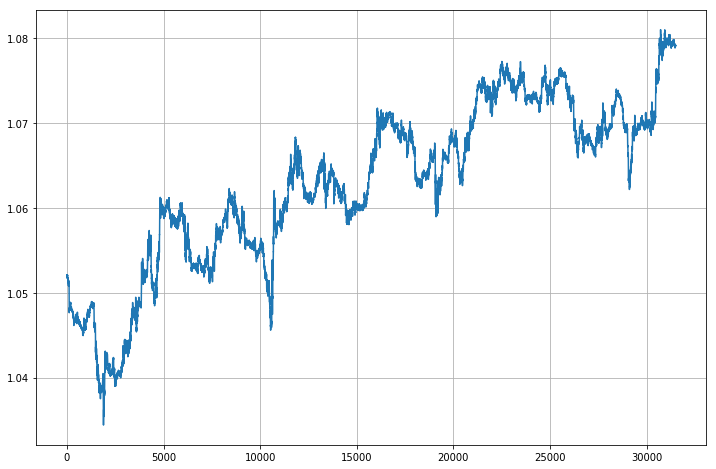

In [3]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(data[:,1])
ax.grid(True)
plt.show()

In [35]:
normal_data = np.copy(data)

max_val = np.max(data[:,1:-1])#-np.min(data[:,1:-1])
#min = np.min(data[:,1:-1])

normal_data = (normal_data[:, 1:-1])/max_val

(31499, 4)


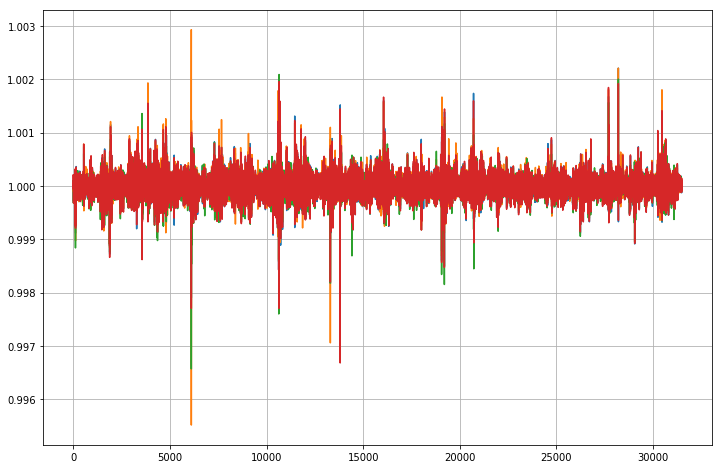

In [42]:
new_data = np.empty(normal_data.shape)

print new_data.shape

for i in range(normal_data[:,0].size):
    
    new_data[i] = normal_data[i]/normal_data[i-1]

new_data = new_data[1:-1]
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(new_data)
ax.grid(True)
plt.show()

In [7]:
# Hyperparams

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

iterations = 2000
learning_rate = 0.1

steps_to_predict = 30

truncated_backprop_length = 30

batch_size = 1
state_size = 8
features = 4

In [8]:
X_batch_Placeholder = tf.placeholder(dtype=tf.float32, shape=[steps_to_predict, batch_size, features])
Y_batch_Placeholder = tf.placeholder(dtype=tf.float32, shape=[steps_to_predict, batch_size, 1])
input_size = tf.placeholder(dtype=tf.int32)

In [9]:
W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

In [18]:
labels_series = tf.split(axis=0, num_or_size_splits=steps_to_predict, value=Y_batch_Placeholder)
inputs_series = X_batch_Placeholder

In [11]:
cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)

In [12]:
cell = tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, inputs_series, initial_state=init_state, time_major=True)

In [19]:
logits_series = []

for i in range(steps_to_predict):

    logits_series.append(tf.matmul(states_series[i], W2) + b2)

losses = [tf.nn.l2_loss(label - logit, name=None) for logit, label in zip(logits_series, labels_series)]
    
total_loss = tf.reduce_mean(losses)

In [46]:
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

_current_cell_state = np.zeros((batch_size, state_size))
_current_hidden_state = np.zeros((batch_size, state_size))

In [51]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

for start_index in range(iterations):

    end_index = start_index + steps_to_predict
    labels_end_index = end_index+steps_to_predict

    batchX = new_data[start_index:end_index].reshape(steps_to_predict, batch_size, features)
    batchY = new_data[end_index:labels_end_index, -1].reshape(steps_to_predict, batch_size, 1)

    _total_loss, _train_step, _current_state = sess.run([total_loss, train_step, current_state],
        feed_dict={
            X_batch_Placeholder:batchX,
            Y_batch_Placeholder:batchY,
            cell_state:_current_cell_state,
            hidden_state:_current_hidden_state
        })
    
    _current_cell_state, _current_hidden_state = _current_state

    if (start_index)%(iterations/20) == 0:
        print 'Step',start_index, 'Loss =', _total_loss

print 'Done Training'

Step 0 Loss = 0.995768
Step 100 Loss = 1.7382e-08
Step 200 Loss = 1.87446e-09
Step 300 Loss = 7.81835e-09
Step 400 Loss = 3.14458e-09
Step 500 Loss = 2.05521e-08
Step 600 Loss = 2.65215e-09
Step 700 Loss = 6.94067e-10
Step 800 Loss = 1.49403e-09
Step 900 Loss = 9.44541e-09
Step 1000 Loss = 6.06153e-09
Step 1100 Loss = 1.69544e-09
Step 1200 Loss = 1.19912e-09
Step 1300 Loss = 3.129e-09
Step 1400 Loss = 9.28424e-09
Step 1500 Loss = 2.39719e-08
Step 1600 Loss = 1.47561e-08
Step 1700 Loss = 1.23168e-08
Step 1800 Loss = 4.73089e-09
Step 1900 Loss = 4.97414e-08
Done Training


[5 3]
